# Full Procrustres Means for irregular sparse shapes using Hermitian covariance smoothing

In [1]:
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
#for basis representation of full proc mean
library(mboost, quietly = TRUE, warn.conflicts = FALSE)
library(shapeboost, quietly = TRUE, warn.conflicts = FALSE)

# For plotsize in Notebook
options(repr.plot.width=4, repr.plot.height=4)

This is mboost 2.9-3. See ‘package?mboost’ and ‘news(package  = "mboost")’
for a complete list of changes.




In [2]:
# load digit 3 example data from shapes package
d3 <- shapes::digit3.dat

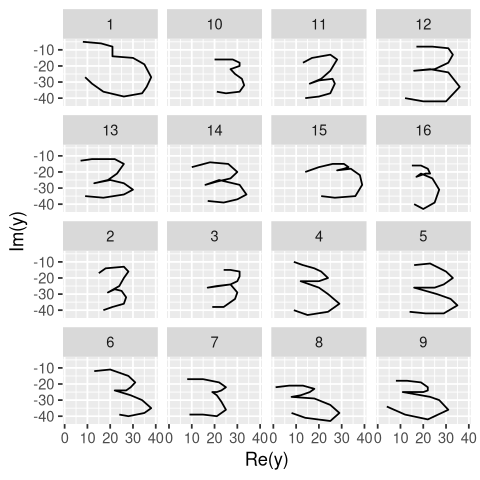

In [3]:
## apply relative "arc-length" parametrization
# first move to complex representation for convenience
d3 <- complex(re = d3[,1,], im = d3[,2,]) %>% 
  matrix(nrow =dim(d3)[1])
d3 <-apply(d3, 2, function(x) data.frame(y = x))
d3 <-bind_rows(d3, .id = "id")
# now get parametrization as y(arg)
d3 <- d3 %>% group_by(id )%>% 
  mutate(arg =cumsum(c(0,Mod(diff(y)))) )%>% 
  mutate(arg = arg/max(arg))%>% ungroup()

d3 %>% filter(id%in%1:16) %>% 
  ggplot(aes(Re(y),Im(y)))+ geom_path()+ facet_wrap(~id)

In [4]:
# now represent d3 in a'very long'with y real and
# both dimensions in one column
d3 <-lapply(list(x = Re, y = Im), function(f) mutate(d3, y =f(y))) %>% 
  bind_rows(.id = "dim")

In [5]:
# calculate functional full procrustres mean shape
mean_d3 <- planarshape_full_proc(formula = y^dim~ bbs(arg) | id,
                                 data = d3, 
                                 smoothed.cov = TRUE,
                                 arg.grid.len = 50)

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.



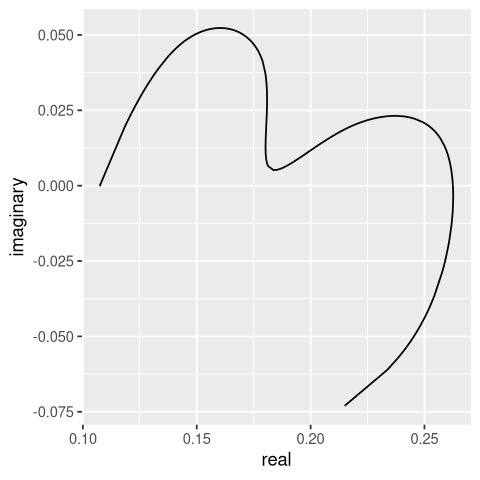

In [6]:
# depict result
mean_d3 %>% as_shape_frame_default() %>% arrange(arg) %>%
  ggplot(aes(real, imaginary)) + geom_path()

In [7]:
planarshape_full_proc <- function (formula, data, cyclic = FALSE, smoothed.cov = FALSE, 
    cov.k = 10, arg.grid.len = 50, weights = NULL, arg.range = NULL, 
    mf = NULL, mfboost.return = FALSE) 
{
    basics <- mfInterpret_cplx_curves(formula = formula, data = data, 
        weights = weights, arg.range = arg.range)
    mod0_data <- basics$mod0_data
    response <- basics$response
    av <- basics$variable_names
    if (is.array(response)) 
        mod0_data[[av["value"]]] <- response
    if (is.array(response)) {
        arg_form <- if (formula[[3]][[1]] == "|") 
            formula[[3]][[2]]
        else formula[[3]]
        val_form <- formula[[2]][[3]][[2]]
    }
    else {
        arg_form <- if (formula[[3]][[1]] == "|") 
            formula[[3]][[2]]
        else formula[[3]]
        val_form <- formula(mod0_data)[[2]][[2]]
    }
    mod0_formula <- as.formula(paste0(deparse(val_form), "~", 
        deparse(arg_form)), env = environment(formula))
    g2 <- Gaussian()
    g2@check_y <- function(y) y
    g2@offset <- function(y, weights) 0
    mod0 <- mboost(mod0_formula, mod0_data, family = g2, control = boost_control(mstop = 0))
    if (length(mod0$baselearner) != 1) 
        stop("Exactly one base-learner has to be specified for the pole.")
    bl <- mod0$baselearner[[1]]
    nameid <- av["id"]
    .id <- mod0_data[[nameid]]
    ydimvar <- av["dim"]
    nameydim <- ydimvar
    .dim <- mod0_data[[ydimvar]]
    if (length(unique(.dim)) != 2) 
        stop("Only planar 2-dimensional shapes provided, yet.")
    if (!is.array(response)) {
        if (!is.null(dim(response))) 
            stop("If not supplied as an array, the response has to be a vector.")
        if (length(.id) != length(response)) 
            stop("id must be of same length as response.")
    }
    nameyarg <- av["arg"]
    .arg <- mod0_data[[nameyarg]]
    if (!is.array(response)) 
        stopifnot(length(.arg) == length(response))
    if (is.null(arg.range)) 
        arg.range <- environment(bl$dpp)$args$knots[[1]]$boundary.knots
    arg.grid <- if (is.array(response)) 
        .arg
    else {
        if (is.numeric(.arg)) 
            head(seq(arg.range[1], arg.range[2], len = arg.grid.len), 
                arg.grid.len - cyclic)
        else stop("Irregular (long data format) version for non-numeric arg-values \n           not implemented, yet.")
    }
    if (is.null(weights)) 
        weights <- "equal"
    make_integration_weights <- function(weights, arg = NULL, 
        range = NULL) {
        switch(weights, equal = NULL, trapezoidal = trapez_weights(arg, 
            range = range), simpson = simpson_weights(arg, range = range))
    }
    A <- make_integration_weights(weights, arg.grid, arg.range)
    B <- as.matrix(extract(bl, "design"))
    B.grid <- if (is.array(response)) 
        B
    else {
        newdat <- data.frame(.arg = arg.grid)
        names(newdat) <- nameyarg
        B.grid <- as.matrix(with(newdat, mboost::extract(eval(str2expression(bl$get_call())), 
            "design")))
    }
    if (is.null(smoothed.cov)) {
        smoothed.cov <- !is.array(response) & is.numeric(.arg)
    }
    compute_ByyB <- function(value, B, int.weights = NULL, yy) {
        if (missing(yy)) 
            yy <- tcrossprod(value, Conj(value))
        ByyB <- if (is.null(int.weights)) 
            crossprod(B, yy) %*% B
        else {
            if (is.null(dim(int.weights))) 
                crossprod(int.weights * B, yy) %*% (int.weights * 
                  B)
            else crossprod(int.weights %*% B, yy) %*% int.weights %*% 
                B
        }
        ByyB
    }
    if (!smoothed.cov) {
        if (is.array(response)) {
            as_complex <- function(x) {
                matrix(complex(real = x[, 1, ], imaginary = x[, 
                  2, ]), nrow = dim(x)[1])
            }
            ByyB <- compute_ByyB(as_complex(response), B, A)
        }
        else {
            as_complex <- function(x) {
                complex(real = x[, 1], imaginary = x[, 2])
            }
            B_ <- as.data.frame(cbind(response, .arg, B))
            B_ <- split(B_, .id)
            B_ <- lapply(B_, as.matrix)
            ByyB <- sapply(B_, function(B_id) {
                A <- make_integration_weights(weights, arg = B_id[1:(nrow(B_id)/2), 
                  2], arg.range)
                compute_ByyB(value = as_complex(matrix(B_id[, 
                  1], ncol = 2)), B = B_id[1:(nrow(B_id)/2), 
                  -(1:2)], A)
            })
            ByyB <- matrix(rowSums(ByyB), ncol = ncol(B))
        }
    }
    else {
        require(mgcv)
        if (!is.numeric(.arg)) 
            stop("If 'smoothed.cov = TRUE', the arg variable in the formula has to be numeric.")
        cresponse <- as_shape_frame_complex(mod0_data)
        cov_dat <- lapply(split(cresponse, cresponse[[av["id"]]]), 
            function(x) {
                combs <- combn(1:nrow(x), 2)
                data.frame(yy = x[[av["value"]]][combs[1, ]] * 
                  Conj(x[[av["value"]]][combs[2, ]]), arg1 = x[[av["arg"]]][combs[1, 
                  ]], arg2 = x[[av["arg"]]][combs[2, ]])
            })
        cov_dat <- do.call(rbind, cov_dat)
        cov_fit_re <- bam(Re(yy) ~ s(arg1, arg2, bs = "sps", 
            k = cov.k, xt = list(cyclic = cyclic)), data = cov_dat, 
            knots = list(arg1 = arg.range))
        cov_fit_im <- bam(Im(yy) ~ -1 + s(arg1, arg2, bs = "sps", 
            k = cov.k, xt = list(skew = TRUE, cyclic = cyclic)), 
            data = cov_dat, knots = list(arg1 = arg.range))
        cov_dat <- expand.grid(arg1 = arg.grid, arg2 = arg.grid)
        yy <- matrix(complex(real = predict(cov_fit_re, newdata = cov_dat), 
            imaginary = predict(cov_fit_im, newdata = cov_dat)), 
            ncol = length(arg.grid))
        ByyB <- compute_ByyB(yy = yy, B = B.grid, int.weights = A)
    }
    if (is.null(A)) 
        R <- crossprod(B.grid)
    else {
        if (is.null(dim(A))) 
            R <- crossprod(B.grid, A * B.grid)
        else {
            R <- crossprod(B.grid, A %*% B.grid)
        }
    }
    R <- as.matrix(R)
    ei <- eigen(as.matrix(solve(R)) %*% ByyB)
    pole_coefs = ei$vectors[, 1]
    if (is.array(response)) {
        pole_ <- B %*% pole_coefs
    }
    else {
        dim1 <- .dim == unique(.dim)[1]
        pole_ <- B[dim1, ] %*% pole_coefs
    }
    if (mfboost.return) {
        tangent_basis <- complex2realmat(Null(R %*% cbind(pole_coefs, 
            1)))
        tangent <- function(bl) btrafo(bl, tangent_basis)
        pole_ <- if (is.array(response)) 
            lapply(seq_len(dim(response)[3]), function(i) pole_)
        else {
            if (!exists("cresponse")) 
                cresponse <- as_shape_frame_complex(data)
            ids <- cresponse[[nameid]]
            ids <- ordered(ids, levels = unique(ids))
            split(pole_, ids)
        }
        attr(pole_, "tangent") <- tangent
    }
    else {
        pole_ <- if (is.array(response)) 
            cbind(Re(pole_), Im(pole_))
        else {
            if (!exists("cresponse")) 
                cresponse <- as_shape_frame_complex(mod0_data)
            cresponse[[av["value"]]] <- pole_
            as_shape_frame_long(cresponse)
        }
    }
    pole_
}

function (formula, data, cyclic = FALSE, smoothed.cov = FALSE, 
    cov.k = 10, arg.grid.len = 50, weights = NULL, arg.range = NULL, 
    mf = NULL, mfboost.return = FALSE) 
{
    basics <- mfInterpret_cplx_curves(formula = formula, data = data, 
        weights = weights, arg.range = arg.range)
    mod0_data <- basics$mod0_data
    response <- basics$response
    av <- basics$variable_names
    if (is.array(response)) 
        mod0_data[[av["value"]]] <- response
    if (is.array(response)) {
        arg_form <- if (formula[[3]][[1]] == "|") 
            formula[[3]][[2]]
        else formula[[3]]
        val_form <- formula[[2]][[3]][[2]]
    }
    else {
        arg_form <- if (formula[[3]][[1]] == "|") 
            formula[[3]][[2]]
        else formula[[3]]
        val_form <- formula(mod0_data)[[2]][[2]]
    }
    mod0_formula <- as.formula(paste0(deparse(val_form), "~", 
        deparse(arg_form)), env = environment(formula))
    g2 <- Gaussian()
    g2@check_y <- function(y) y
    g2@offset <- function(y, weights) 0
    mod0 <- mboost(mod0_formula, mod0_data, family = g2, control = boost_control(mstop = 0))
    if (length(mod0$baselearner) != 1) 
        stop("Exactly one base-learner has to be specified for the pole.")
    bl <- mod0$baselearner[[1]]
    nameid <- av["id"]
    .id <- mod0_data[[nameid]]
    ydimvar <- av["dim"]
    nameydim <- ydimvar
    .dim <- mod0_data[[ydimvar]]
    if (length(unique(.dim)) != 2) 
        stop("Only planar 2-dimensional shapes provided, yet.")
    if (!is.array(response)) {
        if (!is.null(dim(response))) 
            stop("If not supplied as an array, the response has to be a vector.")
        if (length(.id) != length(response)) 
            stop("id must be of same length as response.")
    }
    nameyarg <- av["arg"]
    .arg <- mod0_data[[nameyarg]]
    if (!is.array(response)) 
        stopifnot(length(.arg) == length(response))
    if (is.null(arg.range)) 
        arg.range <- environment(bl$dpp)$args$knots[[1]]$boundary.knots
    arg.grid <- if (is.array(response)) 
        .arg
    else {
        if (is.numeric(.arg)) 
            head(seq(arg.range[1], arg.range[2], len = arg.grid.len), 
                arg.grid.len - cyclic)
        else stop("Irregular (long data format) version for non-numeric arg-values \n           not implemented, yet.")
    }
    if (is.null(weights)) 
        weights <- "equal"
    make_integration_weights <- function(weights, arg = NULL, 
        range = NULL) {
        switch(weights, equal = NULL, trapezoidal = trapez_weights(arg, 
            range = range), simpson = simpson_weights(arg, range = range))
    }
    A <- make_integration_weights(weights, arg.grid, arg.range)
    B <- as.matrix(extract(bl, "design"))
    B.grid <- if (is.array(response)) 
        B
    else {
        newdat <- data.frame(.arg = arg.grid)
        names(newdat) <- nameyarg
        B.grid <- as.matrix(with(newdat, mboost::extract(eval(str2expression(bl$get_call())), 
            "design")))
    }
    if (is.null(smoothed.cov)) {
        smoothed.cov <- !is.array(response) & is.numeric(.arg)
    }
    compute_ByyB <- function(value, B, int.weights = NULL, yy) {
        if (missing(yy)) 
            yy <- tcrossprod(value, Conj(value))
        ByyB <- if (is.null(int.weights)) 
            crossprod(B, yy) %*% B
        else {
            if (is.null(dim(int.weights))) 
                crossprod(int.weights * B, yy) %*% (int.weights * 
                  B)
            else crossprod(int.weights %*% B, yy) %*% int.weights %*% 
                B
        }
        ByyB
    }
    if (!smoothed.cov) {
        if (is.array(response)) {
            as_complex <- function(x) {
                matrix(complex(real = x[, 1, ], imaginary = x[, 
                  2, ]), nrow = dim(x)[1])
            }
            ByyB <- compute_ByyB(as_complex(response), B, A)
        }
        else {
            as_complex <- function(x) {
                complex(real = x[, 1], imaginary 